In [1]:
import numpy as np
import pandas as pd
import cv2
from random import randint
import matplotlib.pyplot as plt
import pickle

import importlib
import bespoke_functions as f

from tensorflow import keras, cast, float32

In [3]:
images, labels = f.import_data("train")

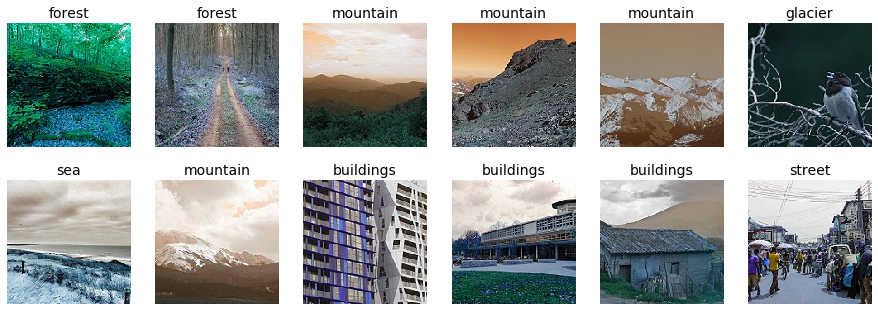

In [4]:
# what do these pictures look like?
plots, ax = plt.subplots(2,6)
plots.subplots_adjust(0,0,2,1)

for down in range(2):
    for across in range(6):
        random_number = randint(0,len(images)) # we'll show a random 12 of the pictures
        ax[down, across].imshow(images[random_number])
        ax[down, across].set_title(labels[random_number],size = 14)
        ax[down, across].axis('off')

In [16]:
# this is a convolutional neural network - a type of network that specialises in image recognition
# the 'convolution' part comes from the first stage - 'convolution/pooling', where key features from the images are extracted

model = keras.models.Sequential() # a sequential model is the simplest neural network

# scans a 150x150x3 tensor (the image) for features, the 'scanning window' is 3x3 pixels
model.add(keras.layers.Conv2D(16, kernel_size = (3,3), input_shape = (150, 150, 3), activation = 'relu'))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2))

model.add(keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2))

model.add(keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2))

model.add(keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2))

# the layer above returns a tensor. We need a single layer matrix so that we can make predictions
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.50))

# make actual predictions
model.add(keras.layers.Dense(6, activation = 'softmax'))

# # configure how the model learns
model.compile(optimizer = keras.optimizers.Adam(lr=0.001), # Adam is a form of SGD that includes momentum
              loss = 'sparse_categorical_crossentropy', # 3+ possibility outcome classification
              metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
dropout_10 (Dropout)         (None, 148, 148, 16)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
dropout_11 (Dropout)         (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 64)       

In [35]:
label_dict = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
labels_nums = np.array(list(map(lambda x: label_dict[x], labels)))
reshaped_images = np.array(images).reshape(14034, 150, 150, 3)

In [1]:
# early stopping - fitting iterations stop if we don't see continued improvement in the validation dataset
es = keras.callbacks.EarlyStopping(min_delta = 0.01, patience = 10, restore_best_weights = True)
training = model.fit(x = reshaped_images,
                     y = labels_nums,
                     verbose = 0,
                     validation_split = 0.15,
                     epochs = 50,
                     callbacks = [es])

In [2]:
# model.save('CNN.h5')
model = keras.models.load_model('CNN.h5')

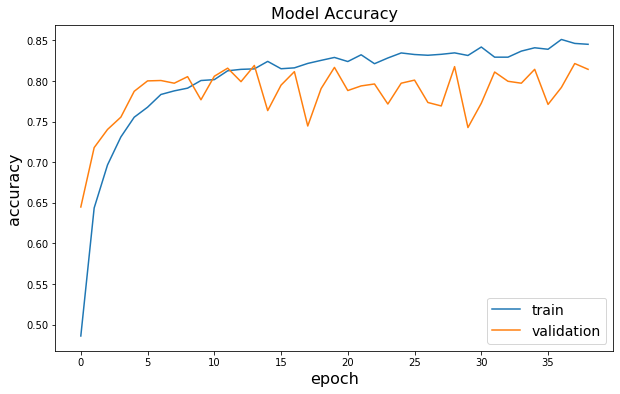

In [23]:
# we just did quite a few epochs (iterations), which could be overfitting. Let's have a look at how train and validation accuracy 
    # changes over time
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(training.history['accuracy'])
ax.plot(training.history['val_accuracy'])
ax.set_title('Model Accuracy', size = 16)
ax.set_ylabel('accuracy', size = 16)
ax.set_xlabel('epoch', size = 16)
ax.legend(['train', 'validation'], loc='lower right', fontsize = 14)

plt.savefig("model_accuracy.png")
plt.show()

In [25]:
# this is looking pretty good! we're overfitting a touch, but it's not too drastic.

In [3]:
test_images, test_labels = f.import_data("test")
label_dict = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
test_labels_nums = np.array(list(map(lambda x: label_dict[x], test_labels)))
test_reshaped_images = np.array(test_images).reshape(3000, 150, 150, 3)

# predict_classes() seems to only work if the input is tf.float32 datatype
test_reshaped_images = cast(test_reshaped_images, float32)

In [4]:
predictions = model.predict_classes(test_reshaped_images) # predictions!

# look up the text labels from our dictionary lookup
label_value_dict = {value: key for key, value in label_dict.items()}
text_labels = list(map(lambda x: label_value_dict[x], predictions))

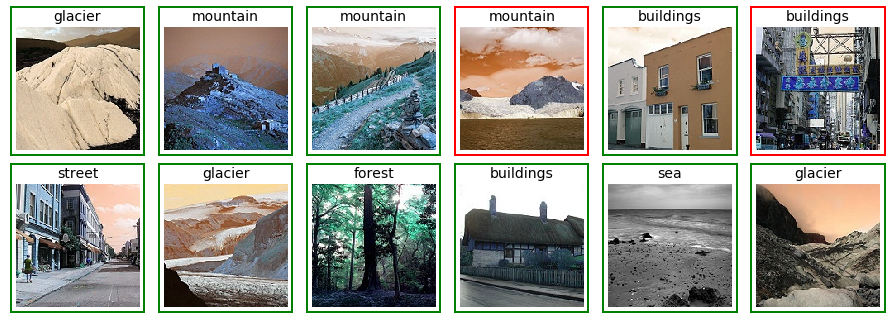

In [88]:
# now lets see some of our predictions - we're right about 80% of the time
plots, ax = plt.subplots(2,6)
plots.subplots_adjust(0,0,2,1)

for down in range(2):
    for across in range(6):
        random_number = randint(0,len(test_images)) # we'll show a random 12 of the pictures
        ax[down, across].imshow(test_images[random_number])
        ax[down, across].set_title(text_labels[random_number],size = 14)

        ax[down, across].set_xticks([], [])
        ax[down, across].set_yticks([], [])
        
        # the border should be green if the prediction is correct, and red if not
        if test_labels[random_number] == text_labels[random_number]:
            for spine in ax[down, across].spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(2)
        else:
            for spine in ax[down, across].spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2)
                
        ax[down, across].spines["top"].set_position(("outward", 20))
        ax[down, across].spines["top"].set_bounds(-5, 155) 

        ax[down, across].spines["bottom"].set_position(("outward", 5))
        ax[down, across].spines["bottom"].set_bounds(-5, 155) 
        
        ax[down, across].spines["left"].set_position(("outward", 5))
        ax[down, across].spines["left"].set_bounds(155, -25)
        
        ax[down, across].spines["right"].set_position(("outward", 5))
        ax[down, across].spines["right"].set_bounds(155, -25) 

plt.show()

In [89]:
plots.savefig("new_predictions.png", bbox_inches = "tight")